281e8a479e56679c452a8d5a0a64bf75082165a5
ba44182af395af67f5157d40a15c49024f0b74a4
dab2e4d8af18612a6b957e9adde14fc0b7d0a33d
e5434937229322b1ec7f633956ff572b16226d88
CVRMSE of client 0 : 41.1561279296875
CVRMSE of client 1 : 8.167862892150879
CVRMSE of client 2 : 11.913650512695312
CVRMSE of client 3 : 8.706056594848633


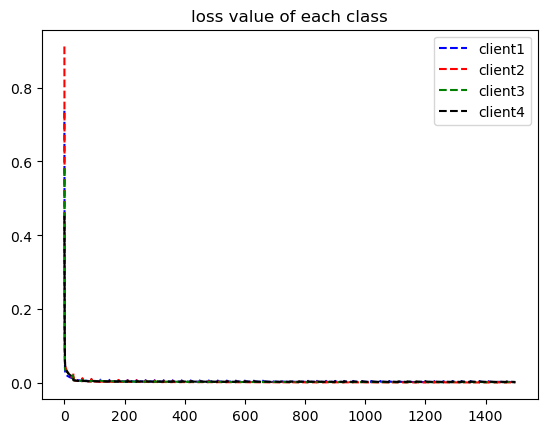

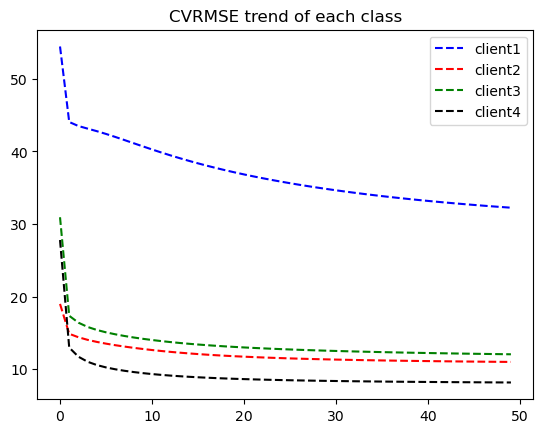

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

def copy_state(state):
    return {k: v.cpu().clone() for k, v in state.items()}

def making_plot(y):
    x = []
    for i in range(len(y)):
        x.append(i)
    return x,y

class FedLearningDataLoader(object):
    #Loading one building data//min-max regularization//shuffling
    def __init__(self, obj_data):
        self.data = obj_data
        self.data.isnull().sum().sum()
        self.data = self.data.dropna()
        colnames = self.data.columns
        self.data = data.drop([data.columns[0], data.columns[16]], axis =1)
        
    
    #Splitting data by the number of client//training(80%) and test(20%)
    def client_data_partition(self):
        client = [];client_ans = [];client_test =[];client_ans_test=[]

        #########modify#########
        groups = self.data.groupby("Identifier")
        temp_result = dict(list(groups))
        for key in temp_result.keys():
            print(key)
        
        client_temp = []; client_ans_temp = []
        for v in temp_result.values():
            v = pd.DataFrame(v)
            v = v.drop([v.columns[13]], axis=1)
            colnames = v.columns
            MS = MinMaxScaler()
            v1 = MS.fit_transform(v)
            v1 = pd.DataFrame(v1, columns=colnames)
            x_data = v1.iloc[:, :-1]
            y_data = v1.iloc[:, [-1]]          
            client_temp.append(x_data)
            client_ans_temp.append(y_data)

        for i in range(len(client_temp)):
            client.append(client_temp[i].iloc[:int(len(client_temp[i])*0.8), :])
            client_ans.append(client_ans_temp[i].iloc[:int(len(client_ans_temp[i])*0.8), :])
            client_test.append(client_temp[i].iloc[int(len(client_temp[i])*0.8):, :])
            client_ans_test.append(client_ans_temp[i].iloc[int(len(client_ans_temp[i])*0.8):, :])
        return client, client_ans, client_test, client_ans_test

'''class FedLearningDataLoader(object):
    #Loading one building data//min-max regularization//shuffling
    def __init__(self, obj_data):
        self.data = obj_data
        self.data.isnull().sum().sum()
        self.data = self.data.dropna()
        colnames = self.data.columns
        MS = MinMaxScaler()
        self.data = MS.fit_transform(self.data)
        data = pd.DataFrame(self.data, columns=colnames)
        data = shuffle(data)
        self.x_data = data.iloc[:, :-1]
        self.y_data = data.iloc[:, [-1]]
    
    #Splitting data by the number of client//training(80%) and test(20%)
    def client_data_partition(self, num):
        client = [];client_ans = [];client_test =[];client_ans_test=[]
        
        split_loc = len(self.x_data)//num
        for i in range(num):
            temp_x = self.x_data.iloc[split_loc*i:split_loc*(i+1), :]
            temp_y = self.y_data.iloc[split_loc*i:split_loc*(i+1), :]
            
            client.append(temp_x.iloc[:int(len(temp_x)*0.8), :])
            client_ans.append(temp_y.iloc[:int(len(temp_y)*0.8), :])
            client_test.append(temp_x.iloc[int(len(temp_x)*0.8):, :])
            client_ans_test.append(temp_y.iloc[int(len(temp_y)*0.8):, :])

        return client, client_ans, client_test, client_ans_test'''
    
class FL_Ridge(object):
    def __init__(self, in_features, out_features, num_client, learning_rate, LAMBDA):
        self.models = []
        self.optimizers = []
        self.num_client = num_client
        for i_client in range(num_client):
            self.models.append(
                nn.ModuleList([
                    nn.Linear(in_features = in_features, out_features = out_features, bias = False)
                ])
            )
            #self.optimizers.append(torch.optim.Adam(params=self.models[i_client].parameters(), lr=learning_rate))
            self.optimizers.append(torch.optim.SGD(params=self.models[i_client].parameters(), lr=learning_rate, weight_decay=LAMBDA))
            
        #Add L2_reg by using weight_decay
        self.loss_function = nn.MSELoss()
           
    def train_client(self, i_client, client, client_ans, iteration):
        #calculate ith client part w.r.t current weight and bias
        temp=[]
        for step in range(iteration):
            batch_train = torch.from_numpy(pd.DataFrame.to_numpy(client[i_client], dtype=np.float32))
            index_target = pd.DataFrame.to_numpy(client_ans[i_client], dtype=np.float32)
            
            batch_train.requires_grad = True
            self.optimizers[i_client].zero_grad()
            y = batch_train

            for layer in self.models[i_client]:
                y = layer(y)        

            target = torch.from_numpy(index_target)
            loss = self.loss_function(y, target)
            loss.backward()
            
            # check gradients
            for layer in self.models[i_client]:
                grads = [p.grad for p in layer.parameters()]
                param = [p for p in layer.parameters()]
            self.optimizers[i_client].step()
            
            temp.append(loss.item())

        loss = loss.detach().numpy()
        #print(param)     
        return loss, temp
    
    #Calculate accuracy of the model(CVRMSE)
    def predict_client(self, i_client, client_test, client_ans_test):
        batch_test = torch.from_numpy(pd.DataFrame.to_numpy(client_test[i_client], dtype=np.float32))
        target_test = pd.DataFrame.to_numpy(client_ans_test[i_client], dtype=np.float32)
        
        y = batch_test
        for layer in self.models[i_client]:
            y = layer(y)             
    
        target_test = torch.from_numpy(target_test)
        avg_target = torch.mean(target_test)
        CVRMSE = torch.sqrt(self.loss_function(target_test, y))/avg_target * 100
        return CVRMSE
    
    #Aggregate and average weights of all client part
    def server_aggregate(self):
        #server_aggregate
        state_aggregate = None
        for model in self.models:
            if state_aggregate is None:
                state_aggregate = copy_state(model.state_dict())
                state_aggregate = model.state_dict()
                #print(state_aggregate)
            else:
                for key, value in model.state_dict().items():
                    state_aggregate[key] += value.cpu().clone()       
    
        for key, value in state_aggregate.items():
            state_aggregate[key] /= len(self.models)
            #print(state_aggregate[key])  
        
        # send average model to clinets from server
        for model in self.models:
            model.load_state_dict(state_aggregate, strict=True)
        
        #print(model)
        return
    
########################################################
#From this, the main code starts
########################################################
#data = pd.read_csv('C:/Research/cowork/ISE_537_CA_OneBuilding_Part_1.csv') 
#data = pd.read_csv('C:/Research/cowork/E_Building.csv')
data = pd.read_csv('C:/Research/cowork/ISE_537_4Buildings_Final.csv')
FLDataset = FedLearningDataLoader(data)

#data partitioning <- the number of client is three
(client, client_ans, client_test, client_ans_test) = FLDataset.client_data_partition()


in_features = pd.DataFrame.to_numpy(client[0]).shape[-1]; out_features = 1
num_client = 4; learning_rate = 0.05; LAMBDA = 0.01
communication = 50
training_iter = [30, 30, 30, 30]
FLRidge = FL_Ridge(in_features, out_features, num_client, learning_rate, LAMBDA)

loss_client1 = [];loss_client2 = [];loss_client3 = [];loss_client4 = []  # losses of client loss
CVRMSE1=[];CVRMSE2=[];CVRMSE3=[];CVRMSE4=[] # making plot of accuracy trend through increasing the number of communication
for i in range(communication):
    for i_client in range(num_client):
        (loss, temp) = FLRidge.train_client(i_client, client, client_ans, training_iter[i_client])
        CVRMSE = FLRidge.predict_client(i_client, client_test, client_ans_test)
        if i_client == 0:
            for j in range(len(temp)):
                loss_client1.append(temp[j])
            CVRMSE1.append(CVRMSE.item())
        elif i_client == 1:
            for j in range(len(temp)):
                loss_client2.append(temp[j])
            CVRMSE2.append(CVRMSE.item())
        elif i_client == 2:
            for j in range(len(temp)):
                loss_client3.append(temp[j])   
            CVRMSE3.append(CVRMSE.item())
        elif i_client == 3:
            for j in range(len(temp)):
                loss_client4.append(temp[j])
            CVRMSE4.append(CVRMSE.item())        
    # average weight in server and update
    FLRidge.server_aggregate()
    
    # making plot of accuracy trend through increasing the number of communication


(x1, loss_client1) = making_plot(loss_client1)
(x2, loss_client2) = making_plot(loss_client2)
(x3, loss_client3) = making_plot(loss_client3)
(x4, loss_client4) = making_plot(loss_client4)
(x11, CVRMSE1) = making_plot(CVRMSE1)
(x22, CVRMSE2) = making_plot(CVRMSE2)
(x33, CVRMSE3) = making_plot(CVRMSE3)
(x44, CVRMSE4) = making_plot(CVRMSE4)
plt.figure(1)
plt.title("loss value of each class")
plt.plot(x1, loss_client1, 'b--', label = 'client1')
plt.plot(x2, loss_client2, 'r--', label = 'client2')
plt.plot(x3, loss_client3, 'g--', label = 'client3')
plt.plot(x4, loss_client4, 'k--', label = 'client4')
plt.legend()

plt.figure(2)
plt.title("CVRMSE trend of each class")
plt.plot(x11, CVRMSE1, 'b--', label = 'client1')
plt.plot(x22, CVRMSE2, 'r--', label = 'client2')
plt.plot(x33, CVRMSE3, 'g--', label = 'client3')
plt.plot(x44, CVRMSE4, 'k--', label = 'client4')
plt.legend()


for i_client in range(num_client):
    CVRMSE = FLRidge.predict_client(i_client, client_test, client_ans_test)
    print("CVRMSE of client", i_client, ":", CVRMSE.item())
